In [15]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [16]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [17]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [18]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [19]:
# reflect an existing database into a new model
base = automap_base()
# reflect the tables
base.prepare(engine, reflect = True)

In [20]:
# View all of the classes that automap found
base.classes.keys()

['measurement', 'station']

In [21]:
# Save references to each table
measurement = base.classes.measurement
station = base.classes.station

In [22]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [28]:
earlieststr = session.query(Measurement.date).order_by(Measurement.date).first()
lateststr = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(f"Earliest: {earlieststr[0]} , Latest: {lateststr[0]}")

Earliest: 2010-01-01 , Latest: 2017-08-23


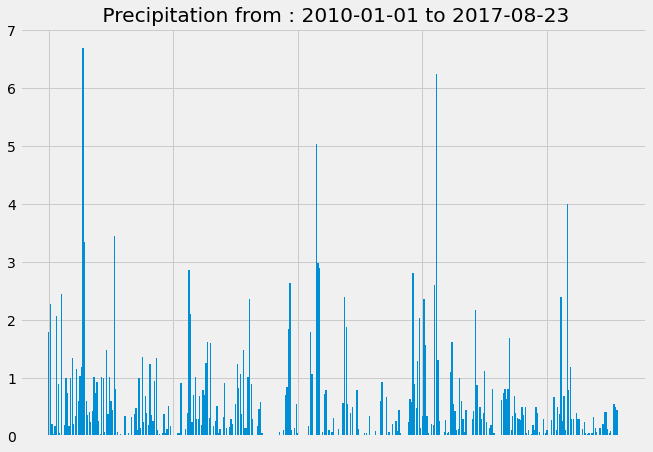

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
lastdate = dt.datetime.strptime(lateststr[0], '%Y-%m-%d')


# Calculate the date one year from the last date in data set.
# Perform a query to retrieve the data and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column
qdate = dt.date(lastdate.year -1, lastdate.month, lastdate.day)
sel = [measurement.date, measurement.prcp]
qresult = session.query(*sel).filter(measurement.date >= qdate).all()
precip = pd.DataFrame(qresult, columns=['Date','precipitation'])
precip = precip.dropna(how='any')

# Sort the dataframe by date
precip= precip.sort_values(["Date"], ascending = True)
precip = precip.set_index("Date")
precip.head()

# Use Pandas Plotting with Matplotlib to plot the data
xx = precip.index.tolist()
yy = precip['precipitation'].tolist()

plt.figure(figsize = (10,7))
plt.bar(xx,yy)
plt.tick_params(
    axis='x',          
    which='both',      
    bottom=False,      
    top=False,         
    labelbottom=False)
majorticks = np.arange(0,400,80)
plt.xticks(majorticks)
plt.title(f" Precipitation from : 2010-01-01 to 2017-08-23")
plt.show()



In [34]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [35]:
# Design a query to calculate the total number stations in the dataset
session.query(station.id).count()

9

In [36]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel = [Measurement.station,func.count(Measurement.id)]
activestations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.id).desc()).all()
activestations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [39]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stationrecord = (session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs),).filter(Measurement.station == activestations[0][0]).all())    
print(f" Most active station is {activestations[0][0]} - {activestations[0][1]}")
print(f"The lowest:{stationrecord[0][0]}F , highest :{stationrecord[0][1]}F, and average :{stationrecord[0][2]}F temperature")

 Most active station is USC00519281 - 2772
The lowest:54.0F , highest :85.0F, and average :71.66378066378067F temperature


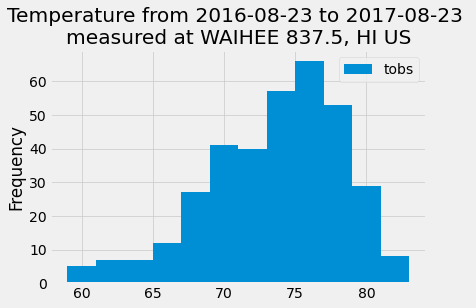

In [44]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
queryresult = session.query(Measurement.tobs).\
    filter(Measurement.station == activestations[0][0]).\
    filter(Measurement.date >= qdate).all()
temperatures = list(np.ravel(queryresult))

sel = [Station.station,Station.name,Station.latitude,Station.longitude,Station.elevation]
queryresult = session.query(*sel).all()
stations_desc = pd.DataFrame(queryresult, columns=['Station','Name','Latitude','Longitude','Elevation'])

stationname = stations_desc.loc[stations_desc["Station"] == activestations[0][0],"Name"].tolist()[0]

plt.hist(temperatures, bins=12,rwidth=1.0,label='tobs')
plt.grid(axis='both', alpha=0.75)
plt.ylabel('Frequency')
plt.title(f"Temperature from {qdate} to {lateststr[0]} \nmeasured at {stationname}")
plt.legend()


# Close session

In [ ]:
# Close Session
session.close()